In [1]:
######################################################################################################
## Etapa 0: Importando as bibliotecas necessárias
######################################################################################################
import os
import time

from concurrent.futures import ThreadPoolExecutor
from src.modules.image import Image, display_image
from src.modules.detection import Detection, display_image_with_detections
from src.modules.canny import Canny, display_canny
from src.modules.adjacency_matrix import AdjacencyMatrix
from src.modules.connected_components import ConnectedComponents, highlight_components
from src.modules.mst import MinimunSpanningTree
from src.modules.build_tree import BuildTree, plot_logest_path
from src.modules.sort_points import SortPoints, plot_sorted_points
from src.modules.compute_splines import ComputeSplines, plot_splines

In [2]:
def process_image(file_path):
    try:
        start_step1 = time.time()
        print("Etapa 1: Leitura da imagem")
        img = Image(file_path)
        img.reading_image()
        end_step1 = time.time()


        # Etapa 2: Detecção de características
        print("Etapa 2: Detecção de características")
        detection = Detection(img.gray_image)
        detection.compute_all_detections()
        end_step2 = time.time()


        # Etapa 3: Detecção de bordas
        print("Etapa 3: Detecção de bordas")
        canny = Canny(detection.mouth.img, detection.nose.img, detection.left_eye.img, detection.right_eye.img)
        canny.compute_all_edges()
        end_step3 = time.time()


        # Etapa 4: Criação das matrizes de adjacência
        print("Etapa 4: Criação das matrizes de adjacência")
        adjacency_matrix = AdjacencyMatrix(canny.mouth_dict, canny.nose_dict, canny.left_eye_dict, canny.right_eye_dict)
        adjacency_matrix.compute_all_matrices()
        end_step4 = time.time()

        # Etapa 5: Cálculo de componentes conectados para cada matriz
        print("Etapa 5: Cálculo de componentes conectados para cada matriz")
        components_results = ConnectedComponents(adjacency_matrix.nose_adjacency_matrix, adjacency_matrix.mouth_adjacency_matrix, adjacency_matrix.left_eye_adjacency_matrix, adjacency_matrix.right_eye_adjacency_matrix)
        components_results.compute_all_components()
        components_results.compute_main_cc()
        end_step5 = time.time()
        # Etapa 6: Cálculo da árvore geradora mínima
        print("Etapa 6: Cálculo da árvore geradora mínima")
        mst = MinimunSpanningTree(components_results.dic_main_nose_cc, components_results.dic_main_mouth_cc, components_results.dic_main_left_eye_cc, components_results.dic_main_right_eye_cc,
                                  adjacency_matrix.nose_adjacency_matrix, adjacency_matrix.mouth_adjacency_matrix, adjacency_matrix.left_eye_adjacency_matrix, adjacency_matrix.right_eye_adjacency_matrix)
        mst.compute_all_mst()
        end_step6 = time.time()

        # Etapa 7: Construção da árvore e poda
        print("Etapa 7: Construção da árvore e poda")
        tree = BuildTree(mst.min_trees_nose, mst.min_trees_mouth, mst.min_trees_left_eye, mst.min_trees_right_eye)
        tree.compute_all_trees()
        end_step7 = time.time()

        # Etapa 7: Construção da árvore e poda
        print("Etapa 8: Ordenando os pontos")
        sort = SortPoints(tree.new_longest_path_nose, tree.new_longest_path_mouth, tree.new_longest_path_left_eye, tree.new_longest_path_right_eye,
                          mst.nodes_nose, mst.nodes_mouth, mst.nodes_left_eye, mst.nodes_right_eye,
                          canny.nose_dict, canny.mouth_dict, canny.left_eye_dict, canny.right_eye_dict)
        sort.compute_all_coordenates()


        # Etapa 8: Splines
        print("Etapa 8: Splines")
        splines = ComputeSplines(sort.sorted_coord_nose, sort.sorted_coord_mouth, sort.sorted_coord_left_eye, sort.sorted_coord_right_eye)
        splines.compute_all_splines()
        end_step8 = time.time()

        

        print(f"Processado: {file_path}")
        print(f"Tempo1 {end_step1 - start_step1}\nTempo2 {end_step2 - end_step1}\nTempo3 {end_step3 - end_step2}\nTempo4 {end_step4 - end_step3}\nTempo5 {end_step5 - end_step4}\nTempo6 {end_step6 - end_step5}\nTempo7 {end_step7 - end_step6}\nTempo8 {end_step8 - end_step7}")
        return img, detection, canny, adjacency_matrix, components_results, mst, tree, sort, splines

    except Exception as e:
        print(f"Erro ao processar {file_path}: {e}")
        return None

    
    
directory = './unzip_images'

file_paths = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('00029_940519_fa.ppm.ppm'))]

with ThreadPoolExecutor(max_workers=5) as executor:
    results = list(executor.map(process_image, file_paths))



Etapa 1: Leitura da imagem
Etapa 2: Detecção de características
Etapa 3: Detecção de bordas
Etapa 4: Criação das matrizes de adjacência
Etapa 5: Cálculo de componentes conectados para cada matriz
Etapa 6: Cálculo da árvore geradora mínima
Etapa 7: Construção da árvore e poda
Etapa 8: Ordenando os pontos
Etapa 8: Splines
Processado: ./unzip_images\00029_940519_fa.ppm.ppm
Tempo1 0.03561592102050781
Tempo2 1.2066454887390137
Tempo3 0.006606101989746094
Tempo4 0.059607744216918945
Tempo5 0.010293006896972656
Tempo6 0.016794681549072266
Tempo7 0.024475812911987305
Tempo8 0.015510797500610352


In [3]:
display_image(results[0][0].open)


In [4]:

display_image_with_detections(results[0][0].image, results[0][1].face, results[0][1].nose, results[0][1].mouth, results[0][1].left_eye, results[0][1].right_eye)


In [5]:

display_canny(results[0][2].nose_edge, name='03_nose_edge')
display_canny(results[0][2].mouth_edge, name='03_mouth_edge')
display_canny(results[0][2].left_eye_edge, name='03_left_eye_edge')
display_canny(results[0][2].right_eye_edge, name='03_right_eye_edge')

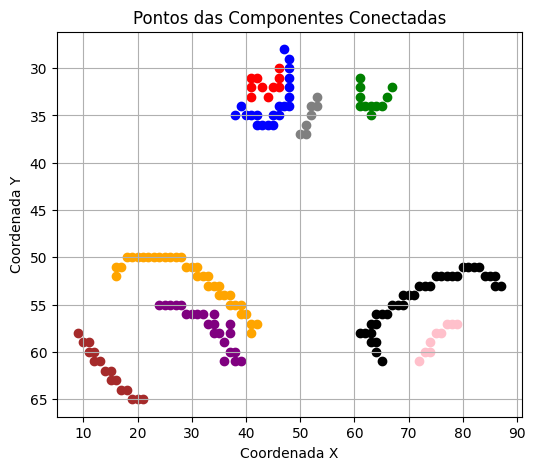

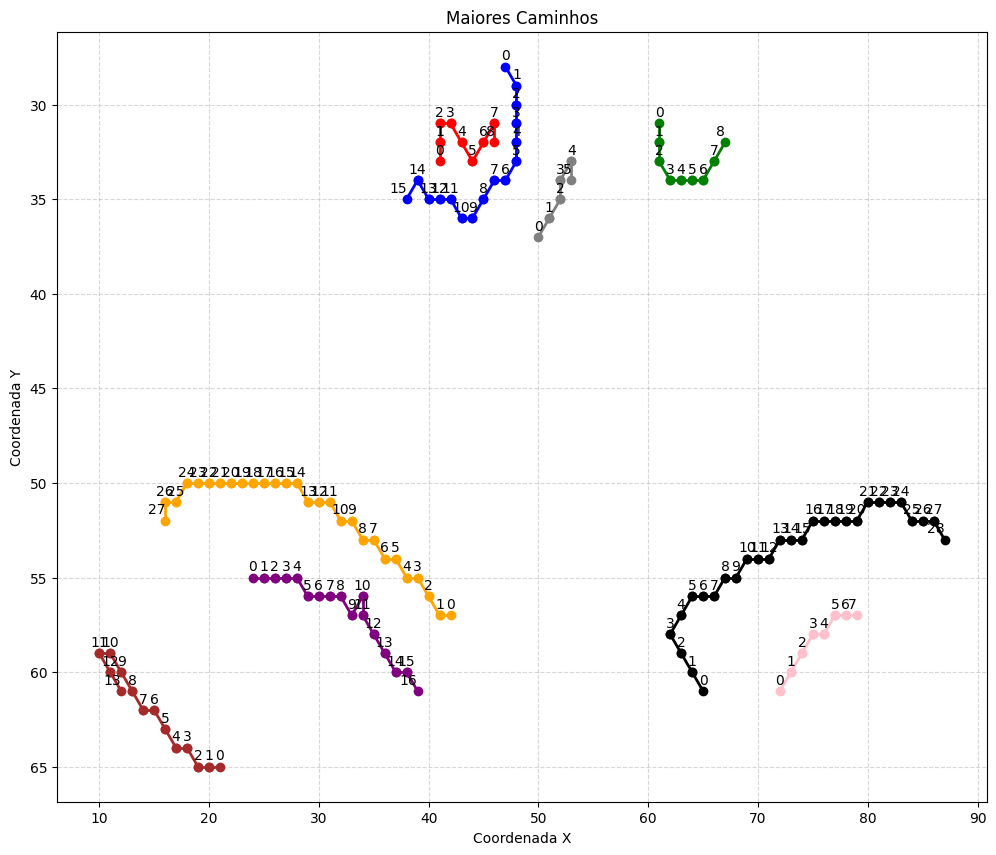

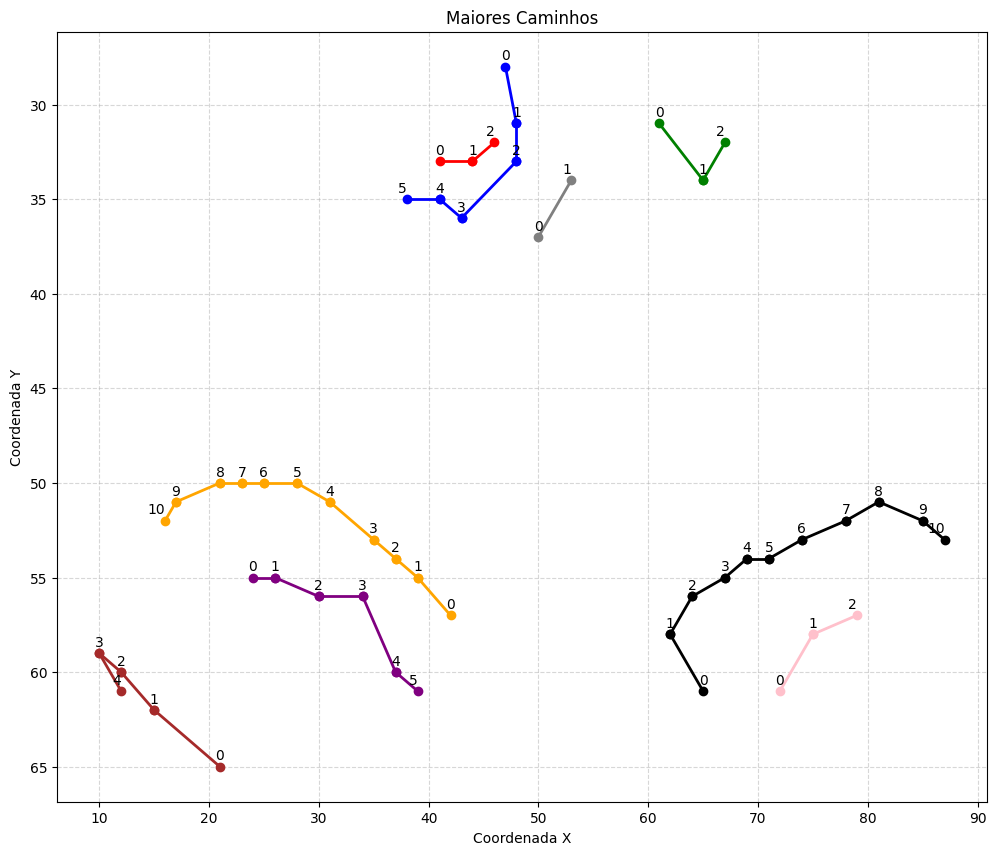

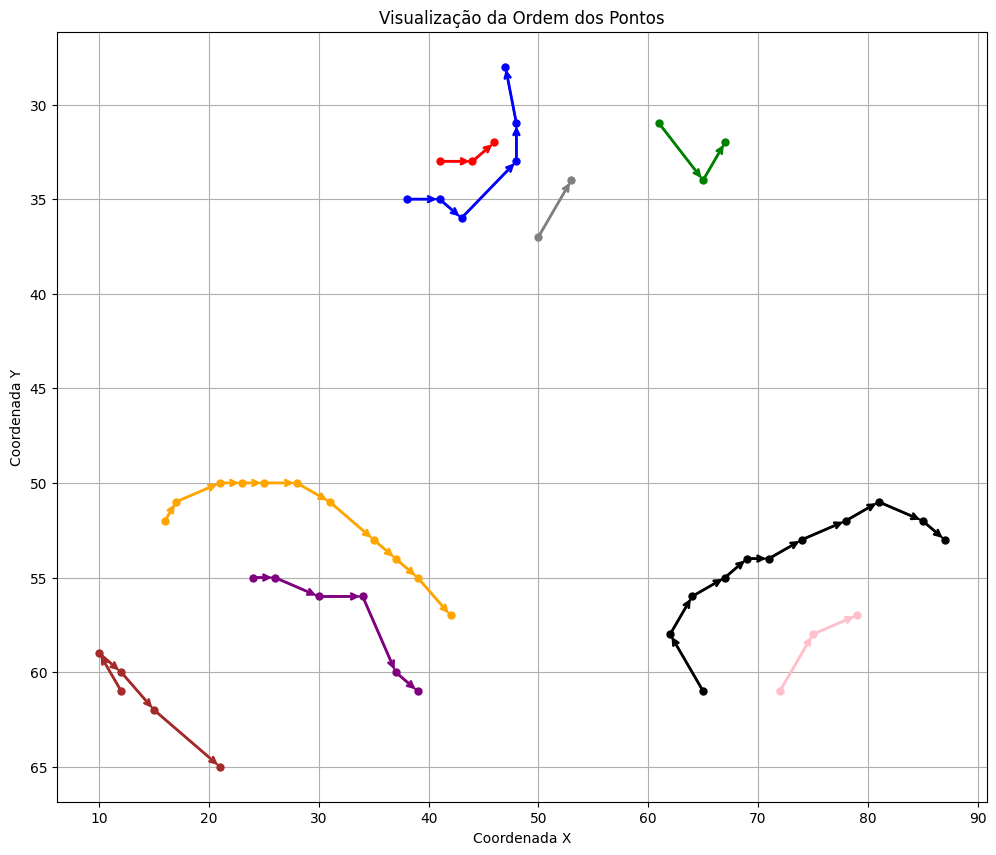

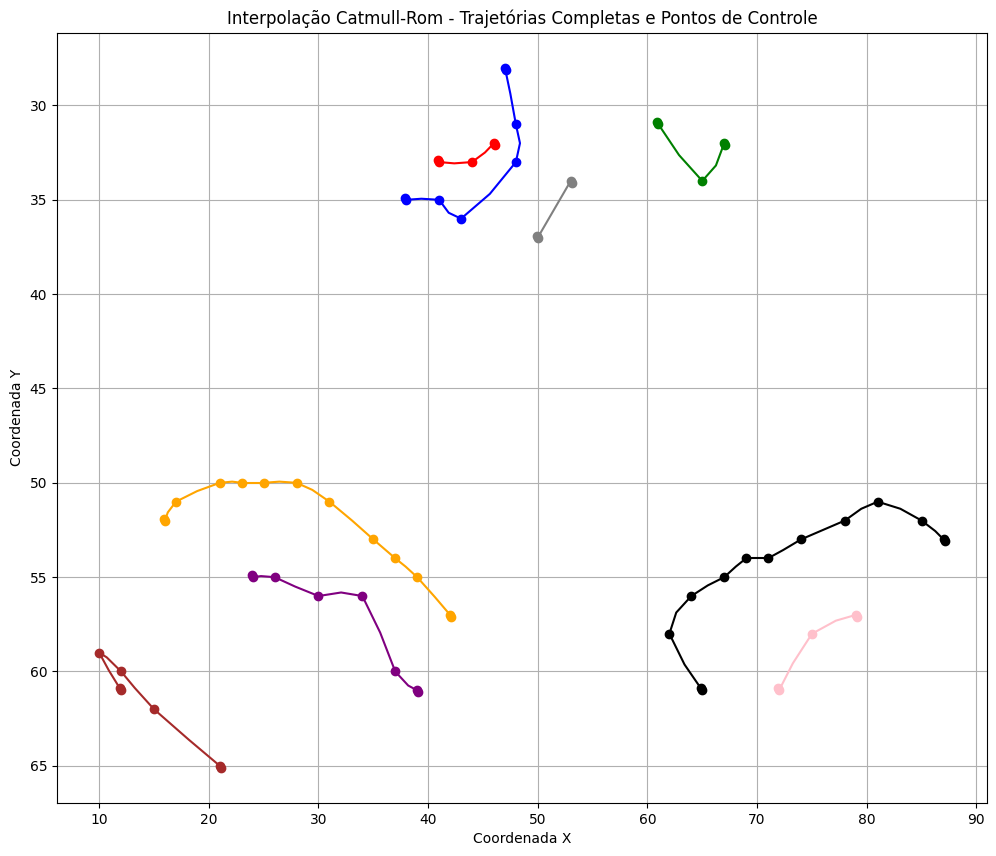

In [6]:
highlight_components(results[0][2].nose_dict, results[0][4].dic_main_nose_cc, "nose")
plot_logest_path(results[0][2].nose_dict, results[0][6].longest_path_nose, results[0][5].nodes_nose, name='05_longest_path_nose')
plot_logest_path(results[0][2].nose_dict, results[0][6].new_longest_path_nose, results[0][5].nodes_nose, name='06_new_longest_path_nose')
plot_sorted_points(results[0][7].sorted_coord_nose, "nose")
plot_splines(results[0][8].all_X_nose, results[0][8].all_Y_nose, results[0][8].all_control_x_nose, results[0][8].all_control_y_nose, name="nose")


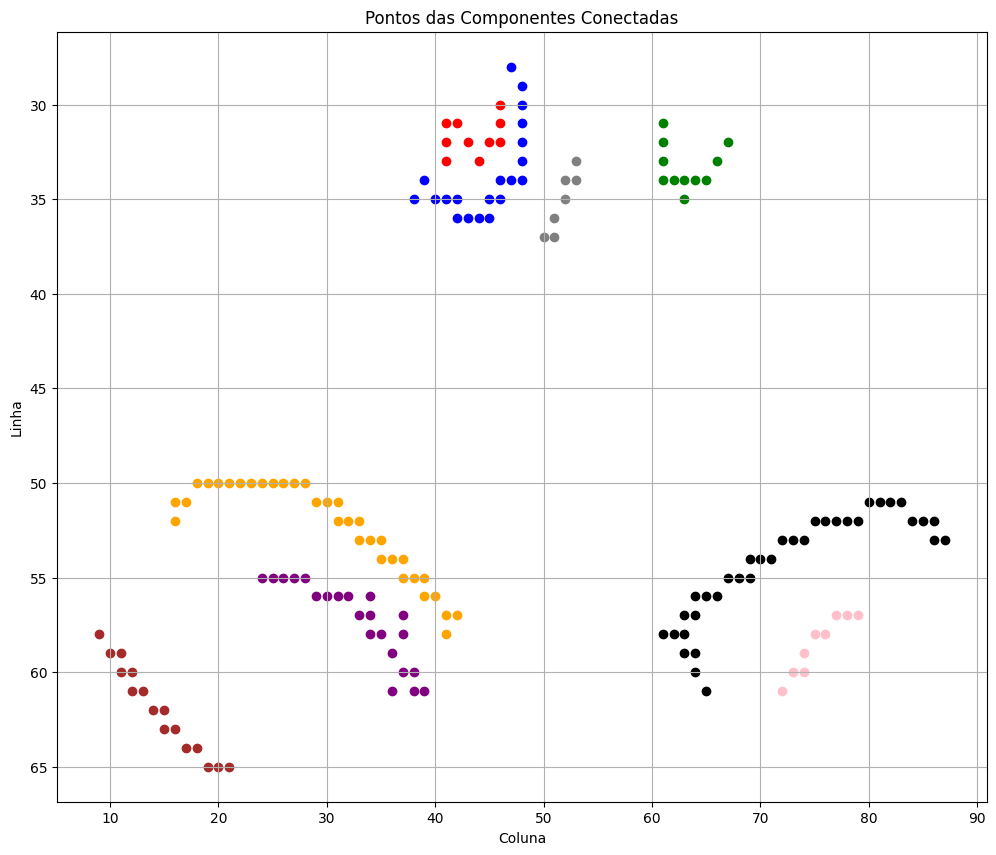

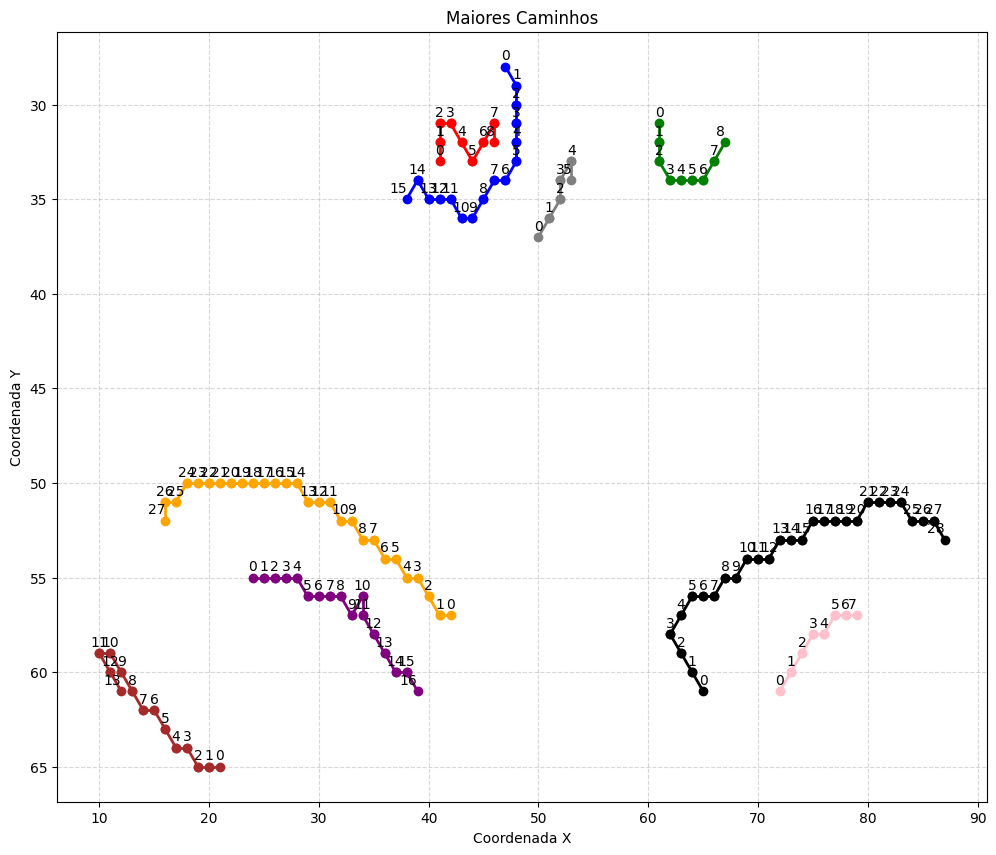

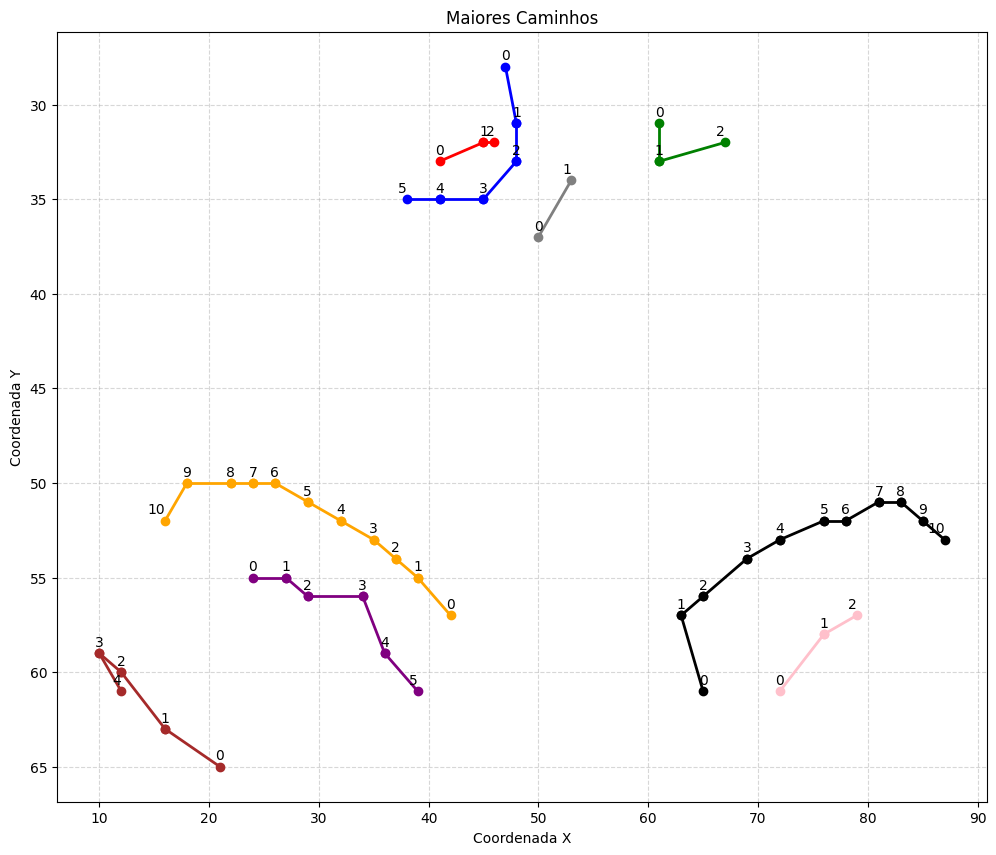

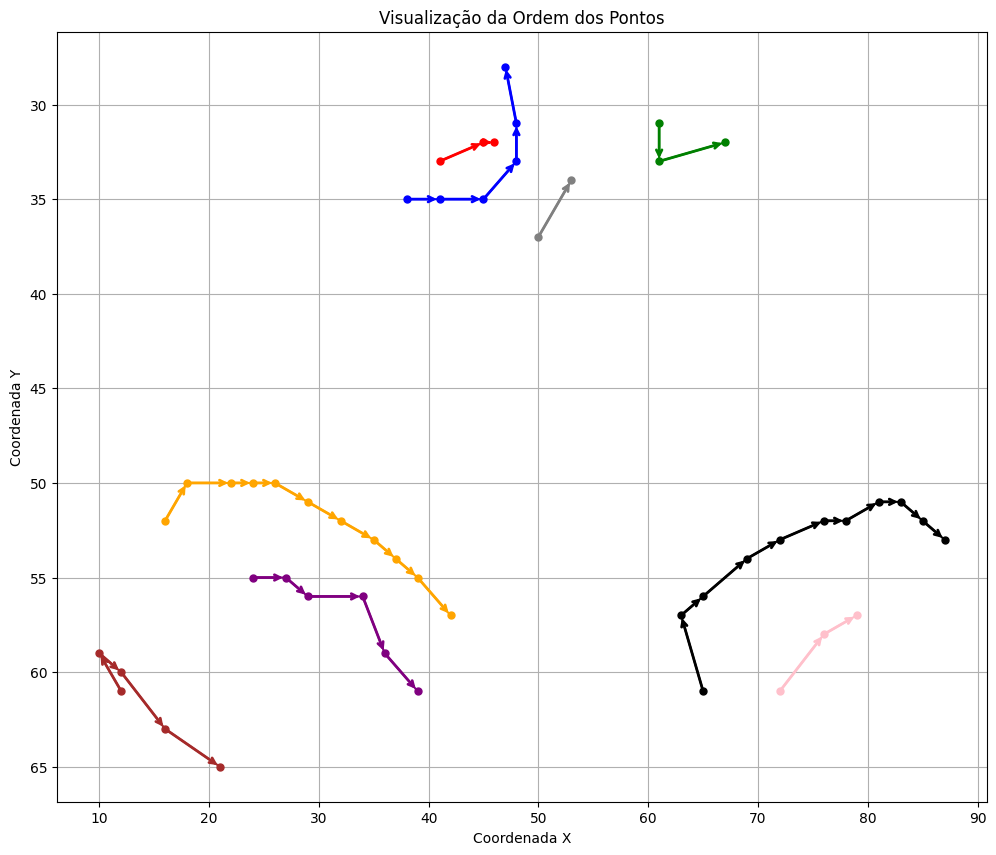

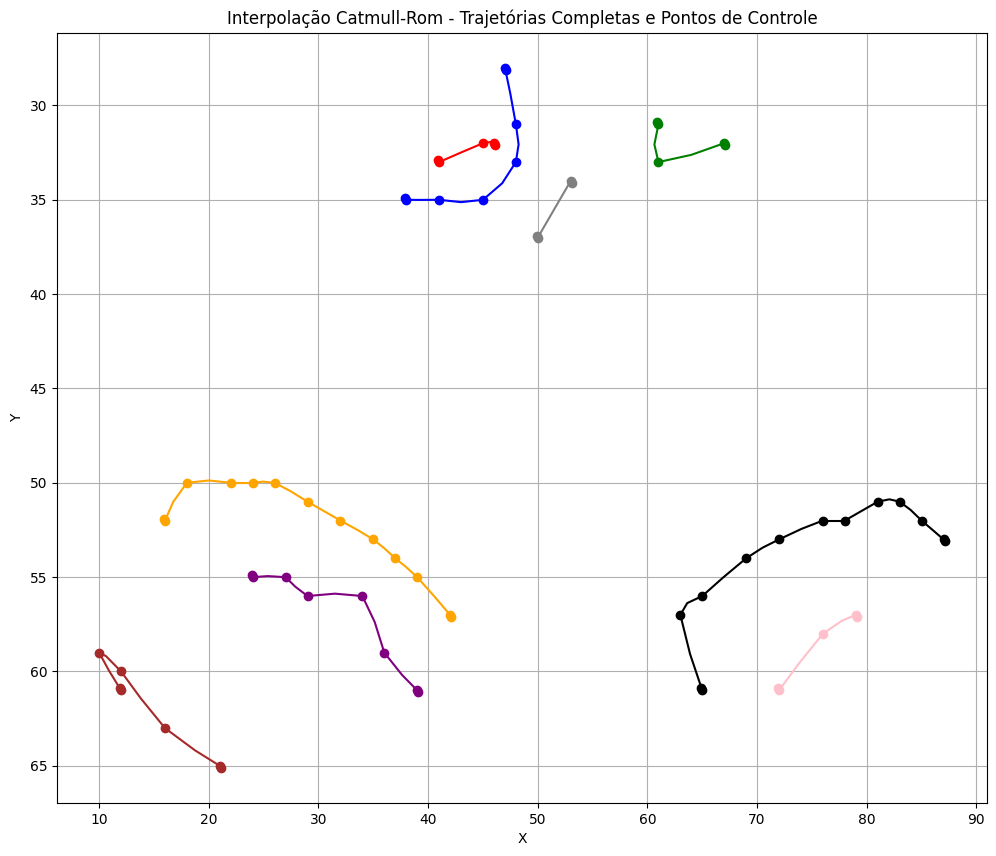

In [15]:
highlight_components(results[0][2].nose_dict, results[0][4].dic_main_nose_cc)
plot_logest_path(results[0][2].nose_dict, results[0][6].longest_path_nose, results[0][5].nodes_nose)
plot_logest_path(results[0][2].nose_dict, results[0][6].new_longest_path_nose, results[0][5].nodes_nose)
plot_sorted_points(results[0][7].sorted_coord_nose)
plot_splines(results[0][8].all_X_nose, results[0][8].all_Y_nose, results[0][8].all_control_x_nose, results[0][8].all_control_y_nose)


In [4]:
import numpy as np
le1 = np.concatenate([arr.flatten() for arr in results[0][7].all_X_left_eye]).tolist()
re1 = np.concatenate([arr.flatten() for arr in results[0][7].all_X_right_eye]).tolist()
m1 = np.concatenate([arr.flatten() for arr in results[0][7].all_X_mouth]).tolist()
n1 = np.concatenate([arr.flatten() for arr in results[0][7].all_X_nose]).tolist()

x1 = np.concatenate([le1, re1, m1, n1]).tolist()

le1 = np.concatenate([arr.flatten() for arr in results[0][7].all_Y_left_eye]).tolist()
re1 = np.concatenate([arr.flatten() for arr in results[0][7].all_Y_right_eye]).tolist()
m1 = np.concatenate([arr.flatten() for arr in results[0][7].all_Y_mouth]).tolist()
n1 = np.concatenate([arr.flatten() for arr in results[0][7].all_Y_nose]).tolist()

y1 = np.concatenate([le1, re1, m1, n1]).tolist()
points1 = list(zip(x1, y1))

In [8]:
le2 = np.concatenate([arr.flatten() for arr in results[1][7].all_X_left_eye]).tolist()
re2 = np.concatenate([arr.flatten() for arr in results[1][7].all_X_right_eye]).tolist()
m2 = np.concatenate([arr.flatten() for arr in results[1][7].all_X_mouth]).tolist()
n2 = np.concatenate([arr.flatten() for arr in results[1][7].all_X_nose]).tolist()

x2 = np.concatenate([le2, re2, m2, n2]).tolist()

le2 = np.concatenate([arr.flatten() for arr in results[1][7].all_Y_left_eye]).tolist()
re2 = np.concatenate([arr.flatten() for arr in results[1][7].all_Y_right_eye]).tolist()
m2 = np.concatenate([arr.flatten() for arr in results[1][7].all_Y_mouth]).tolist()
n2 = np.concatenate([arr.flatten() for arr in results[1][7].all_Y_nose]).tolist()

y2 = np.concatenate([le2, re2, m2, n2]).tolist()
points2 = list(zip(x2, y2))

In [9]:
import numpy as np
le3 = np.concatenate([arr.flatten() for arr in results[2][7].all_X_left_eye]).tolist()
re3 = np.concatenate([arr.flatten() for arr in results[2][7].all_X_right_eye]).tolist()
m3 = np.concatenate([arr.flatten() for arr in results[2][7].all_X_mouth]).tolist()
n3 = np.concatenate([arr.flatten() for arr in results[2][7].all_X_nose]).tolist()

x3 = np.concatenate([le3, re3, m3, n3]).tolist()

le3 = np.concatenate([arr.flatten() for arr in results[2][7].all_Y_left_eye]).tolist()
re3 = np.concatenate([arr.flatten() for arr in results[2][7].all_Y_right_eye]).tolist()
m3 = np.concatenate([arr.flatten() for arr in results[2][7].all_Y_mouth]).tolist()
n3 = np.concatenate([arr.flatten() for arr in results[2][7].all_Y_nose]).tolist()

y3 = np.concatenate([le3, re3, m3, n3]).tolist()

points3 = list(zip(x3, y3))

In [10]:
import numpy as np
le4 = np.concatenate([arr.flatten() for arr in results[3][7].all_X_left_eye]).tolist()
re4 = np.concatenate([arr.flatten() for arr in results[3][7].all_X_right_eye]).tolist()
m4 = np.concatenate([arr.flatten() for arr in results[3][7].all_X_mouth]).tolist()
n4 = np.concatenate([arr.flatten() for arr in results[3][7].all_X_nose]).tolist()

x4 = np.concatenate([le4, re4, m4, n4]).tolist()

le4 = np.concatenate([arr.flatten() for arr in results[3][7].all_Y_left_eye]).tolist()
re4 = np.concatenate([arr.flatten() for arr in results[3][7].all_Y_right_eye]).tolist()
m4 = np.concatenate([arr.flatten() for arr in results[3][7].all_Y_mouth]).tolist()
n4 = np.concatenate([arr.flatten() for arr in results[3][7].all_Y_nose]).tolist()

y4 = np.concatenate([le4, re4, m4, n4]).tolist()

points4 = list(zip(x4, y4))

In [11]:
len(points1), len(points2), len(points3), len(points4)

(395, 337, 280, 275)

In [12]:
points1

[(9.0, 1.0),
 (11.0, 1.0),
 (13.0, 1.0),
 (16.0, 1.0),
 (19.0, 2.0),
 (21.0, 2.0),
 (24.0, 2.0),
 (27.0, 4.0),
 (29.0, 5.0),
 (31.0, 5.0),
 (33.0, 6.0),
 (35.0, 7.0),
 (37.0, 8.0),
 (42.0, 7.0),
 (44.0, 8.0),
 (46.0, 8.0),
 (50.0, 9.0),
 (53.0, 10.0),
 (56.0, 11.0),
 (59.0, 11.0),
 (61.0, 11.0),
 (64.0, 12.0),
 (67.0, 13.0),
 (25.0, 25.0),
 (28.0, 26.0),
 (30.0, 24.0),
 (33.0, 25.0),
 (37.0, 25.0),
 (39.0, 24.0),
 (42.0, 24.0),
 (45.0, 24.0),
 (49.0, 23.0),
 (51.0, 23.0),
 (53.0, 25.0),
 (55.0, 24.0),
 (57.0, 25.0),
 (58.0, 27.0),
 (60.0, 28.0),
 (64.0, 27.0),
 (65.0, 25.0),
 (63.0, 23.0),
 (62.0, 20.0),
 (76.0, 34.0),
 (74.0, 34.0),
 (72.0, 33.0),
 (69.0, 30.0),
 (7.0, 36.0),
 (9.0, 34.0),
 (9.0, 32.0),
 (9.0, 31.0),
 (11.0, 33.0),
 (12.0, 31.0),
 (16.0, 30.0),
 (19.0, 29.0),
 (44.0, 41.0),
 (47.0, 41.0),
 (49.0, 39.0),
 (48.0, 37.0),
 (47.0, 34.0),
 (47.0, 32.0),
 (51.0, 32.0),
 (54.0, 33.0),
 (37.0, 53.0),
 (38.0, 51.0),
 (40.0, 50.0),
 (42.0, 50.0),
 (45.0, 50.0),
 (48.0, 48.0),
 (

In [13]:
import numpy as np

def dtw_2d_curve(series1, series2):
    n, m = len(series1), len(series2)
    dtw_matrix = np.full((n + 1, m + 1), np.inf)
    dtw_matrix[0, 0] = 0

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = np.linalg.norm(np.array(series1[i-1]) - np.array(series2[j-1]))
            dtw_matrix[i, j] = cost + min(
                dtw_matrix[i - 1, j],    # inserção
                dtw_matrix[i, j - 1],    # remoção
                dtw_matrix[i - 1, j - 1] # match
            )

    return dtw_matrix[n, m]

# Calcular a distância DTW entre as curvas
distance = dtw_2d_curve(points1, points2)
print(f"DTW distance (2D curves): {distance:.4f}")

DTW distance (2D curves): 7935.3257


In [14]:
distance = dtw_2d_curve(points1, points3)
print(f"DTW distance (2D curves): {distance:.4f}")

DTW distance (2D curves): 9296.9251


In [15]:
distance = dtw_2d_curve(points1, points4)
print(f"DTW distance (2D curves): {distance:.4f}")

DTW distance (2D curves): 7989.1989


In [16]:
distance = dtw_2d_curve(points2, points3)
print(f"DTW distance (2D curves): {distance:.4f}")

DTW distance (2D curves): 6807.5549


In [17]:
distance = dtw_2d_curve(points2, points4)
print(f"DTW distance (2D curves): {distance:.4f}")

DTW distance (2D curves): 7389.3882


In [18]:
distance = dtw_2d_curve(points3, points4)
print(f"DTW distance (2D curves): {distance:.4f}")

DTW distance (2D curves): 4605.2670


In [4]:
keys = results[2][4].dic_main_left_eye_cc[0]
keys


dicionario_filtrado = {k: v for k, v in results[2][2].left_eye_dict.items() if k in keys}
dicionario_filtrado

{0: (33, 0),
 1: (34, 0),
 2: (35, 0),
 3: (36, 0),
 4: (38, 0),
 12: (32, 1),
 13: (33, 1),
 14: (37, 1),
 15: (38, 1),
 28: (31, 2),
 29: (36, 2),
 30: (37, 2),
 37: (30, 3),
 38: (33, 3),
 39: (34, 3),
 40: (35, 3),
 44: (32, 4),
 47: (31, 5)}

In [5]:
keys

[0, 1, 2, 3, 4, 12, 13, 14, 15, 28, 29, 30, 37, 38, 39, 40, 44, 47]

In [8]:
results[2][5].nodes_left_eye

[[0, 1, 2, 3, 4, 12, 13, 14, 15, 28, 29, 30, 37, 38, 39, 40, 44, 47],
 [7, 8, 9, 10, 11, 18, 19, 20, 21, 22, 23, 24, 25, 32, 33],
 [65,
  66,
  67,
  74,
  75,
  76,
  77,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  97,
  98,
  99,
  100,
  101,
  102,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  123,
  124,
  125,
  126,
  127,
  128,
  135,
  136,
  137,
  138,
  139,
  140,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  160,
  161,
  167,
  170,
  178],
 [108, 109, 121, 122, 133, 134, 143, 144, 145, 158, 159, 166, 169, 176, 182],
 [190,
  191,
  192,
  193,
  194,
  195,
  205,
  206,
  207,
  208,
  209,
  212,
  213,
  214,
  215,
  216,
  217],
 [218,
  219,
  222,
  223,
  224,
  225,
  226,
  227,
  228,
  229,
  230,
  231,
  232,
  233,
  234,
  235,
  236,
  241,
  242,
  247,
  248,
  249,
  265,
  266,
  267,
  273,
  278,
  279,
  289,
  290,
  299,
  300,
  311,
  327,
  328],
 [245,
  246,
  254,
  255,
  256,
  257,
  258,
  259,
  260,
  261,
  262,
  263,
 

In [7]:
results[2][6].longest_path_left_eye

[[17, 16, 13, 14, 15, 10, 7, 3, 2, 1, 0, 5, 9, 12],
 [14, 12, 3, 11, 10, 9, 2, 1, 0, 7, 6, 5],
 [2,
  6,
  5,
  4,
  12,
  11,
  10,
  9,
  18,
  17,
  16,
  22,
  29,
  38,
  45,
  44,
  37,
  36,
  35,
  43,
  42,
  41,
  40,
  34,
  27,
  20,
  14,
  21,
  15,
  8,
  3,
  0,
  1],
 [14, 13, 12, 11, 9, 6, 7, 4, 2, 0, 1],
 [10, 9, 8, 5, 4, 3, 2, 1, 0, 7, 6, 14, 13, 12, 11, 16],
 [33,
  32,
  31,
  28,
  27,
  25,
  23,
  21,
  20,
  18,
  17,
  16,
  15,
  14,
  13,
  12,
  11,
  10,
  1,
  9,
  8,
  7,
  6,
  5,
  4,
  3,
  0,
  2],
 [38,
  37,
  36,
  34,
  33,
  31,
  29,
  27,
  28,
  26,
  24,
  25,
  22,
  18,
  19,
  20,
  13,
  14,
  15,
  2,
  3,
  4,
  0,
  5,
  1,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  17],
 [60,
  53,
  45,
  40,
  36,
  37,
  32,
  27,
  19,
  12,
  6,
  13,
  22,
  29,
  33,
  38,
  43,
  48,
  55,
  56,
  61,
  62,
  63,
  57,
  49,
  50,
  58,
  59,
  51,
  44,
  39,
  34,
  30,
  23,
  15,
  8,
  3,
  0,
  1,
  2,
  5,
  10,
  11,
  17,
  18,
  25,
 

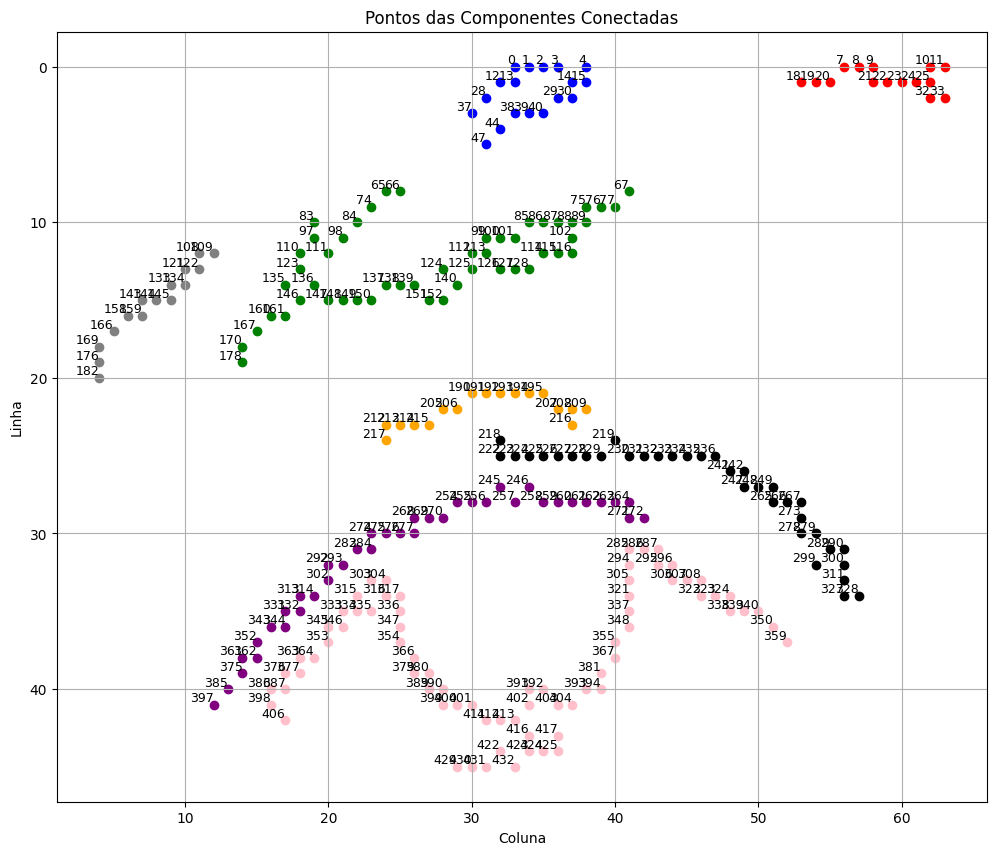

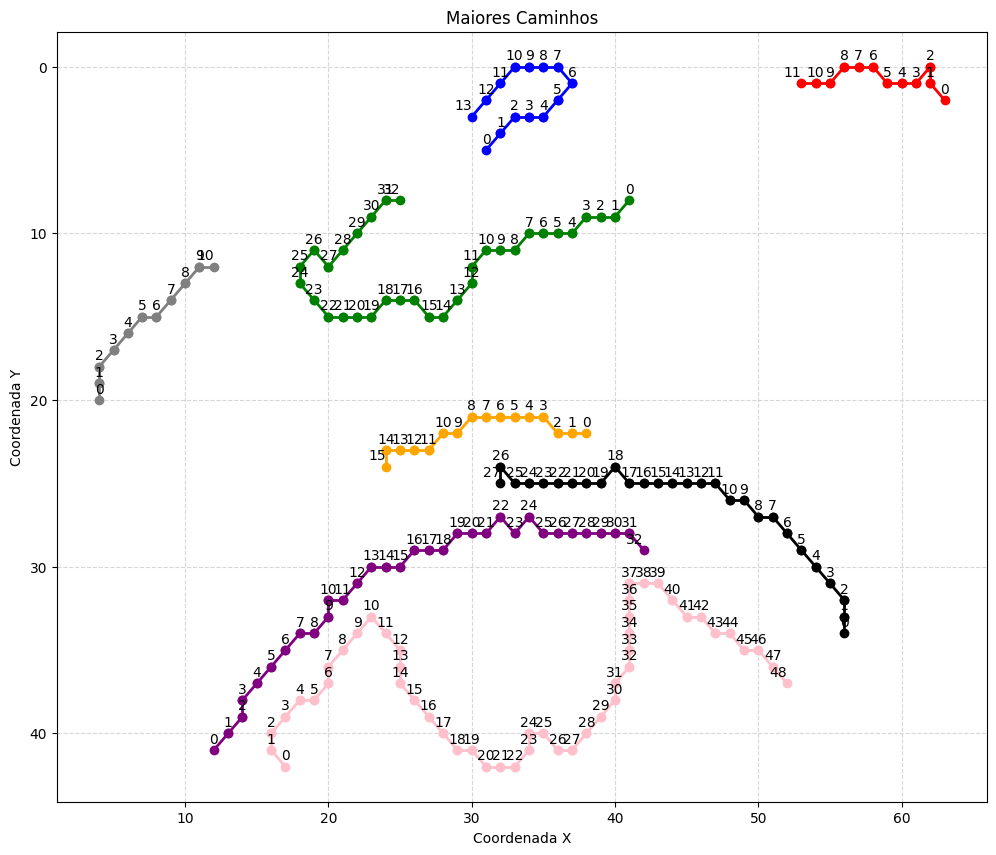

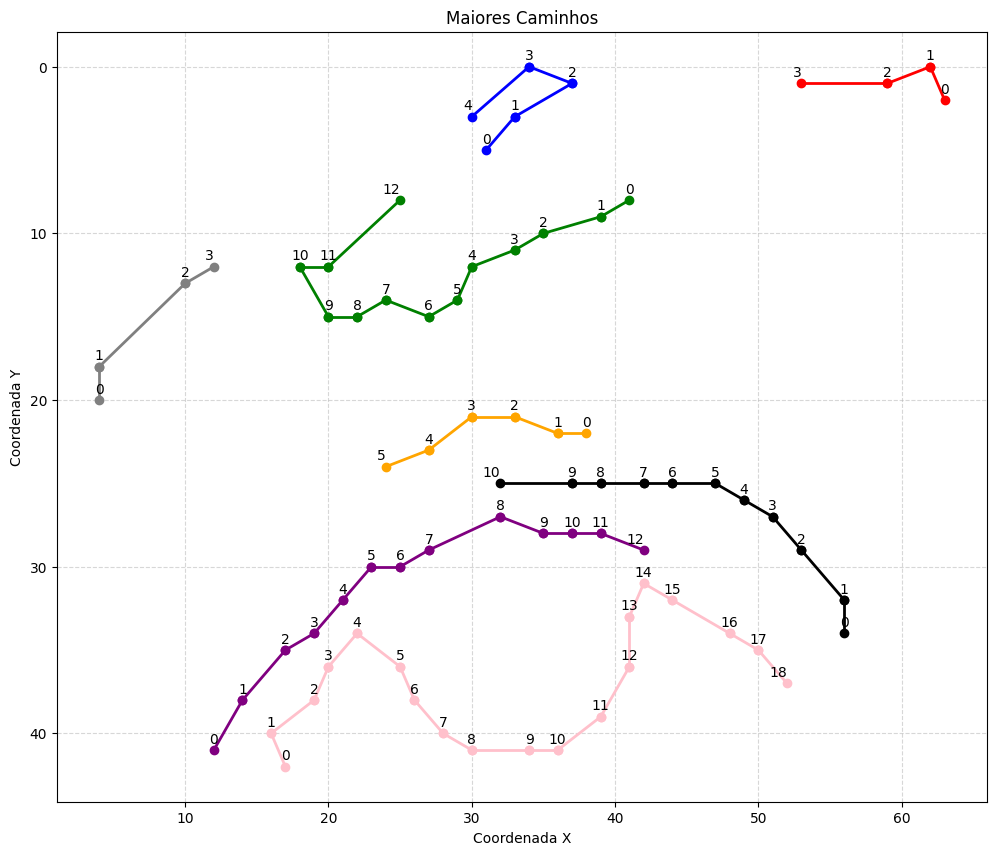

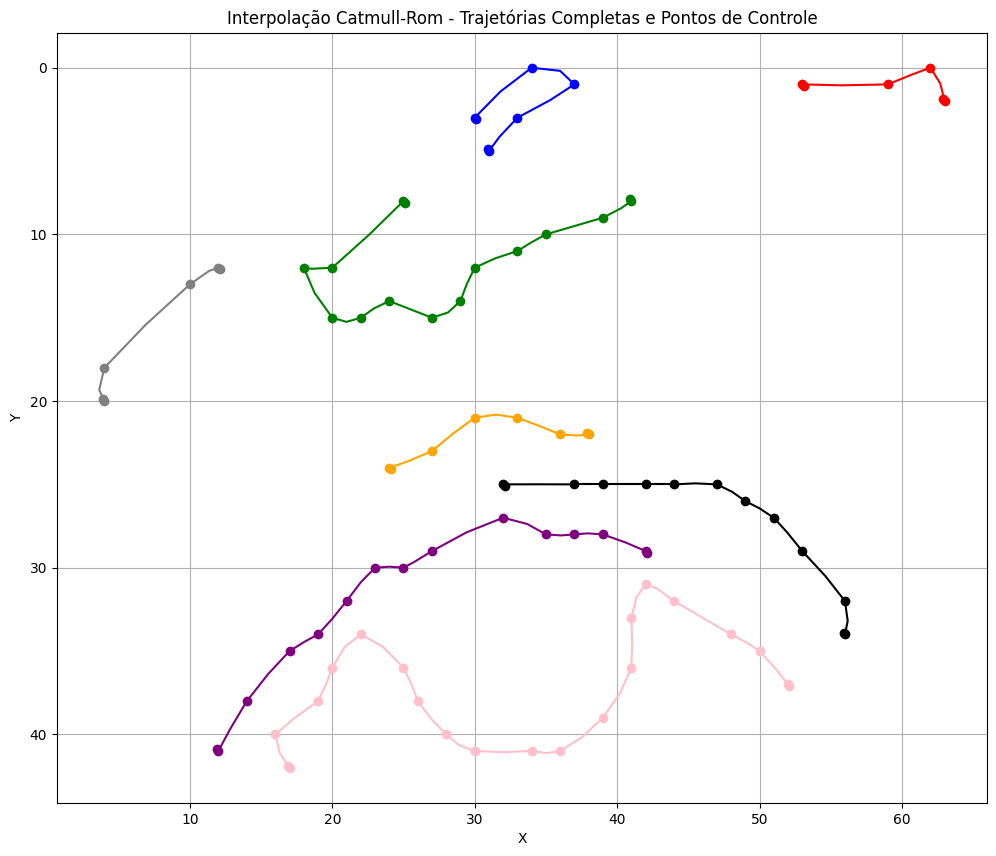

In [3]:
highlight_components(results[2][2].left_eye_dict, results[2][4].dic_main_left_eye_cc)
plot_logest_path(results[2][2].left_eye_dict, results[2][6].longest_path_left_eye, results[2][5].nodes_left_eye)
plot_logest_path(results[2][2].left_eye_dict, results[2][6].new_longest_path_left_eye, results[2][5].nodes_left_eye)
plot_splines(results[2][7].all_X_left_eye, results[2][7].all_Y_left_eye, results[2][7].all_control_x_left_eye, results[2][7].all_control_y_left_eye)


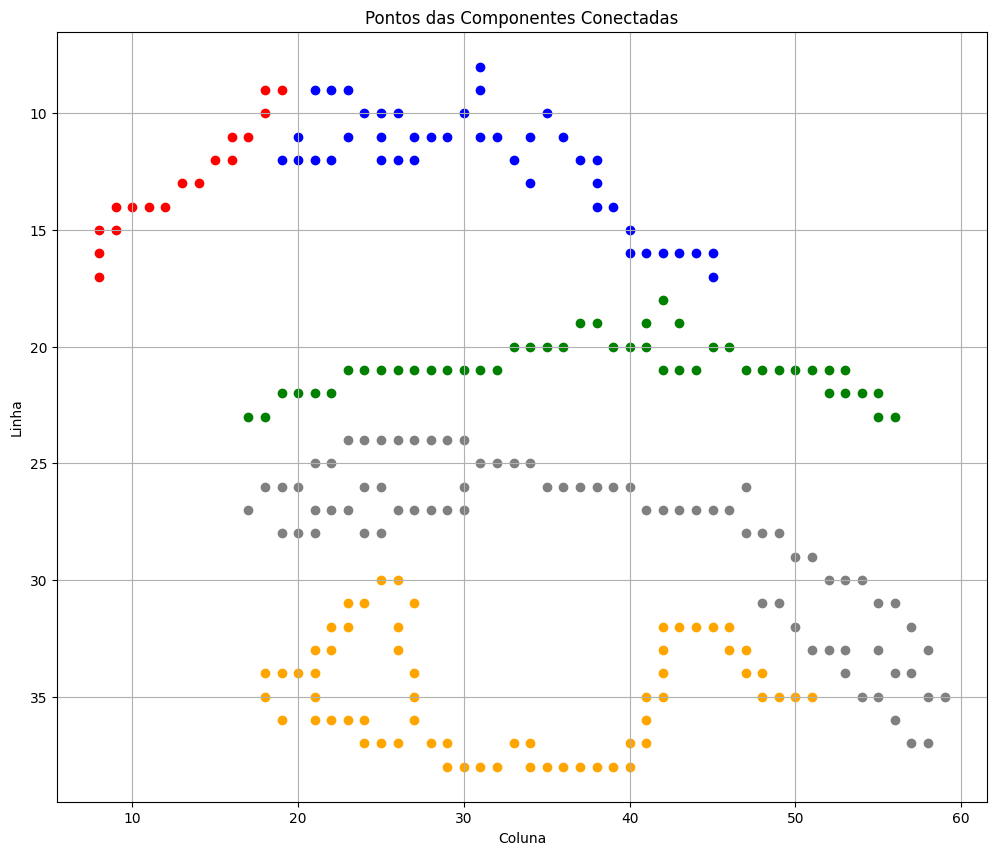

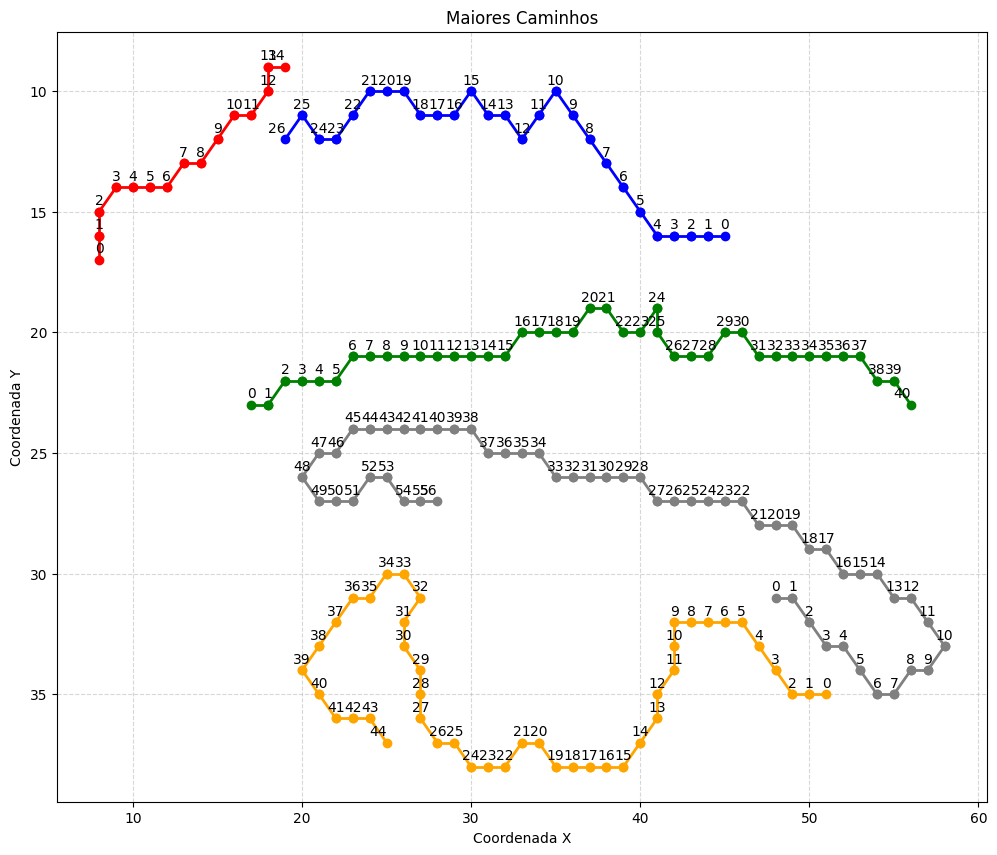

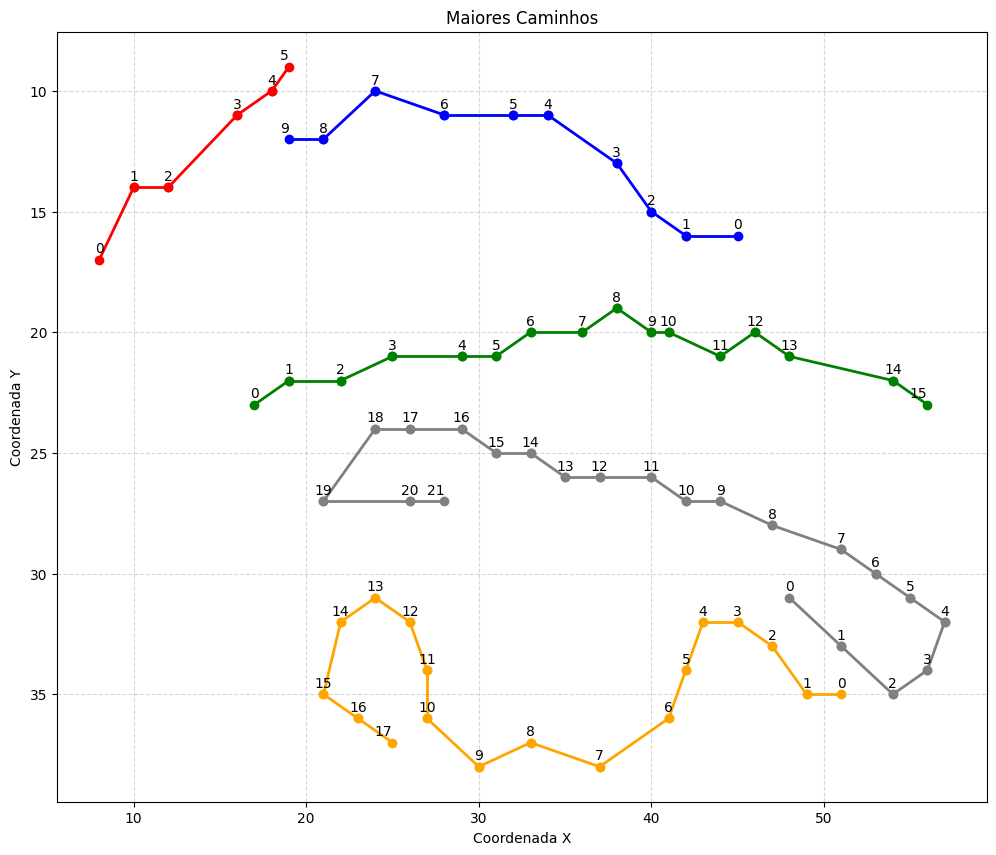

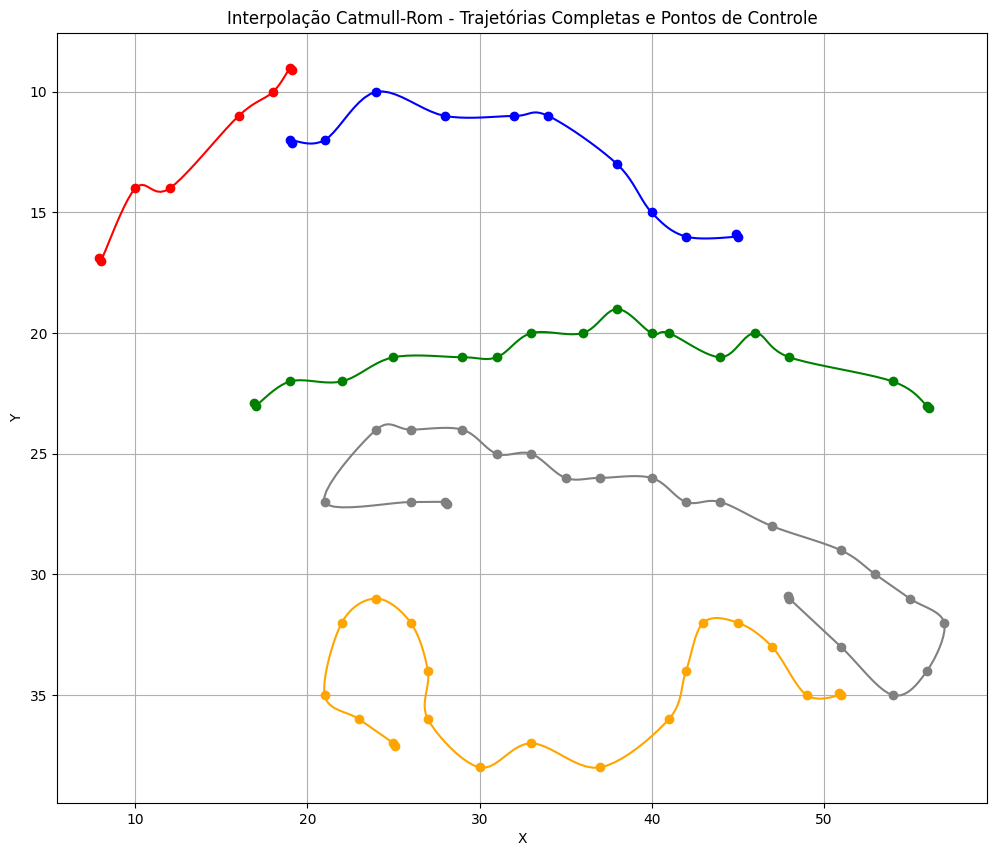

In [4]:
highlight_components(results[0][2].right_eye_dict, results[0][4].dic_main_right_eye_cc)
plot_logest_path(results[0][2].right_eye_dict, results[0][6].longest_path_right_eye, results[0][5].nodes_right_eye)
plot_logest_path(results[0][2].right_eye_dict, results[0][6].new_longest_path_right_eye, results[0][5].nodes_right_eye)
plot_splines(results[0][7].all_X_right_eye, results[0][7].all_Y_right_eye, results[0][7].all_control_x_right_eye, results[0][7].all_control_y_right_eye)


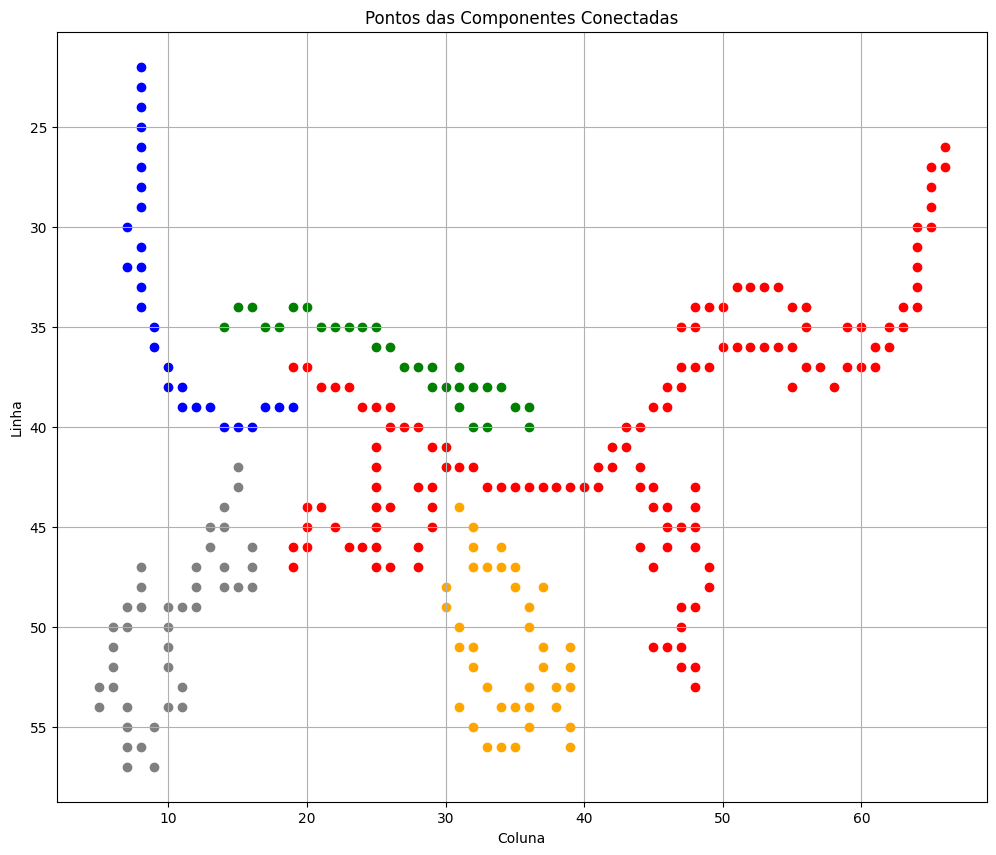

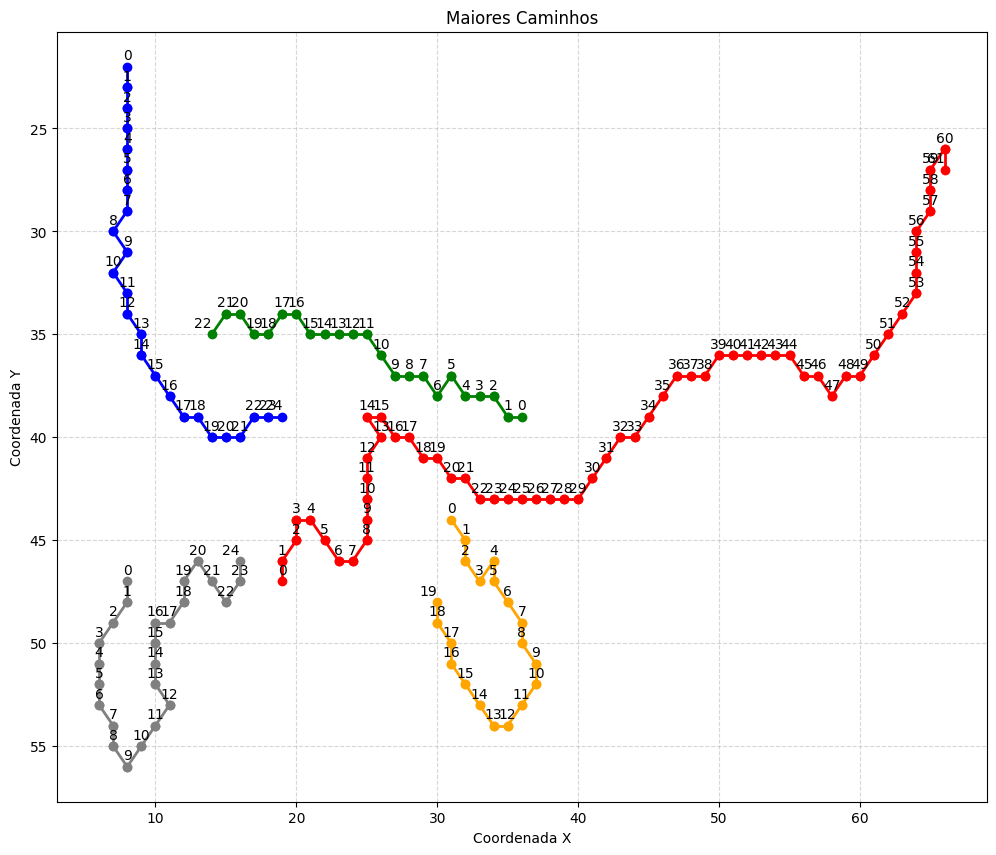

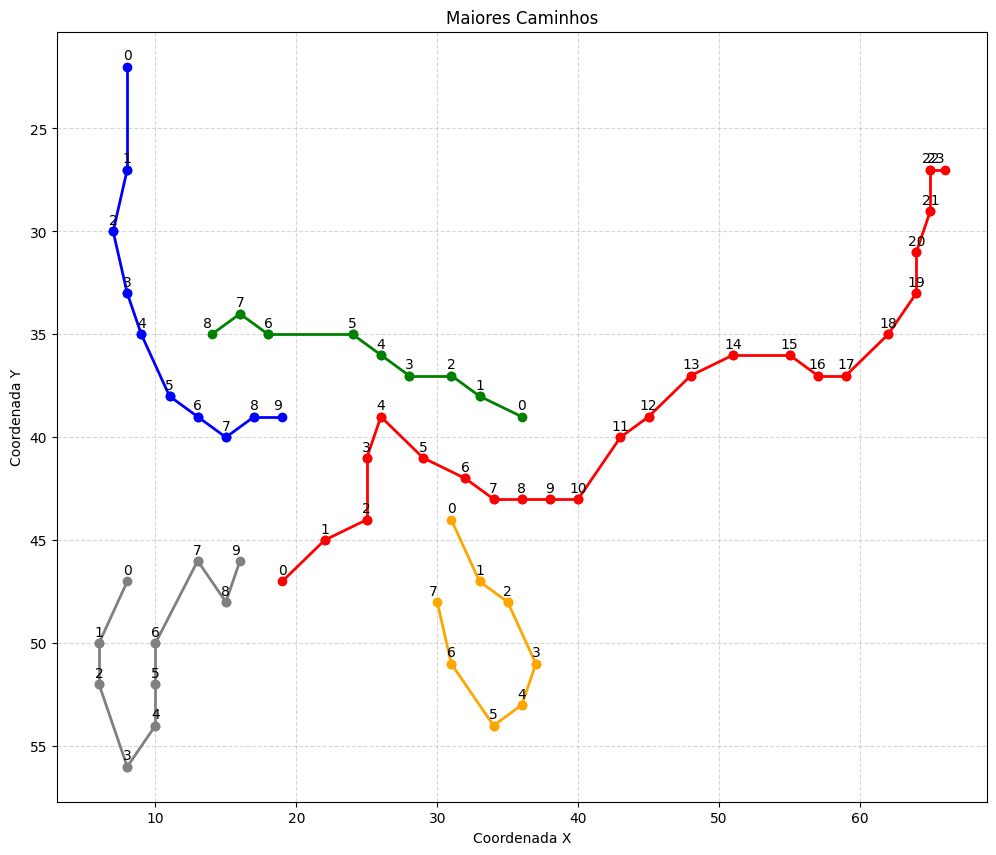

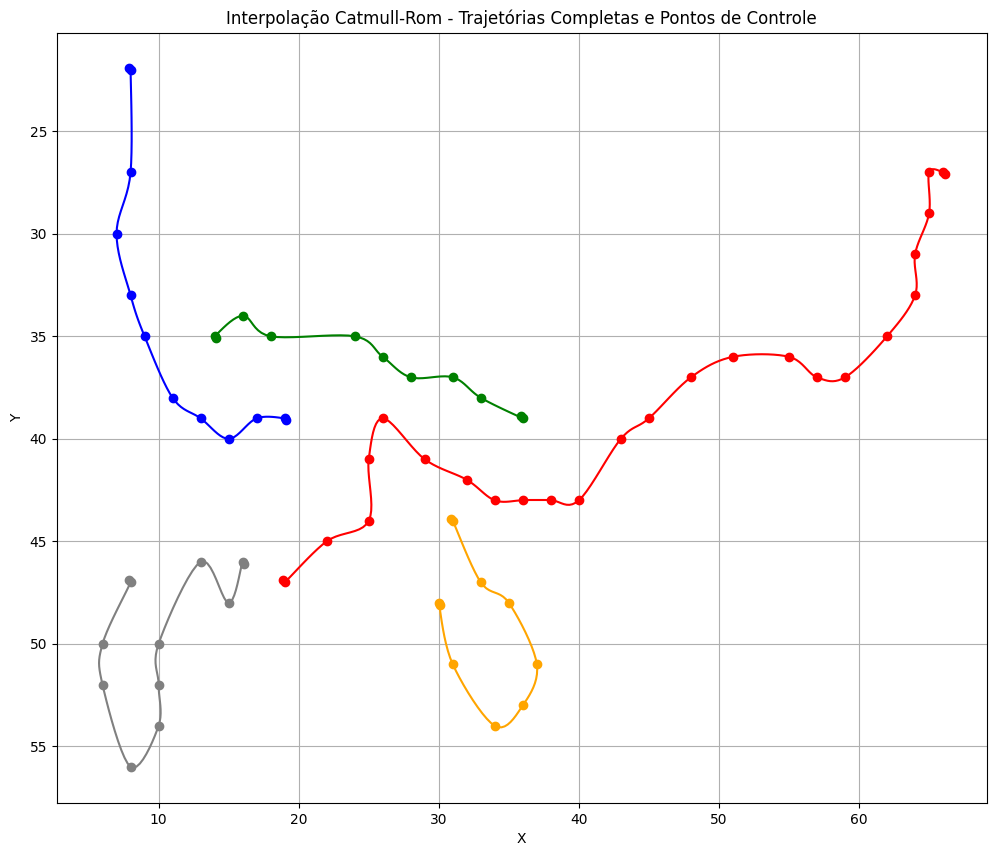

In [5]:
highlight_components(results[0][2].nose_dict, results[0][4].dic_main_nose_cc)
plot_logest_path(results[0][2].nose_dict, results[0][6].longest_path_nose, results[0][5].nodes_nose)
plot_logest_path(results[0][2].nose_dict, results[0][6].new_longest_path_nose, results[0][5].nodes_nose)
plot_splines(results[0][7].all_X_nose, results[0][7].all_Y_nose, results[0][7].all_control_x_nose, results[0][7].all_control_y_nose)


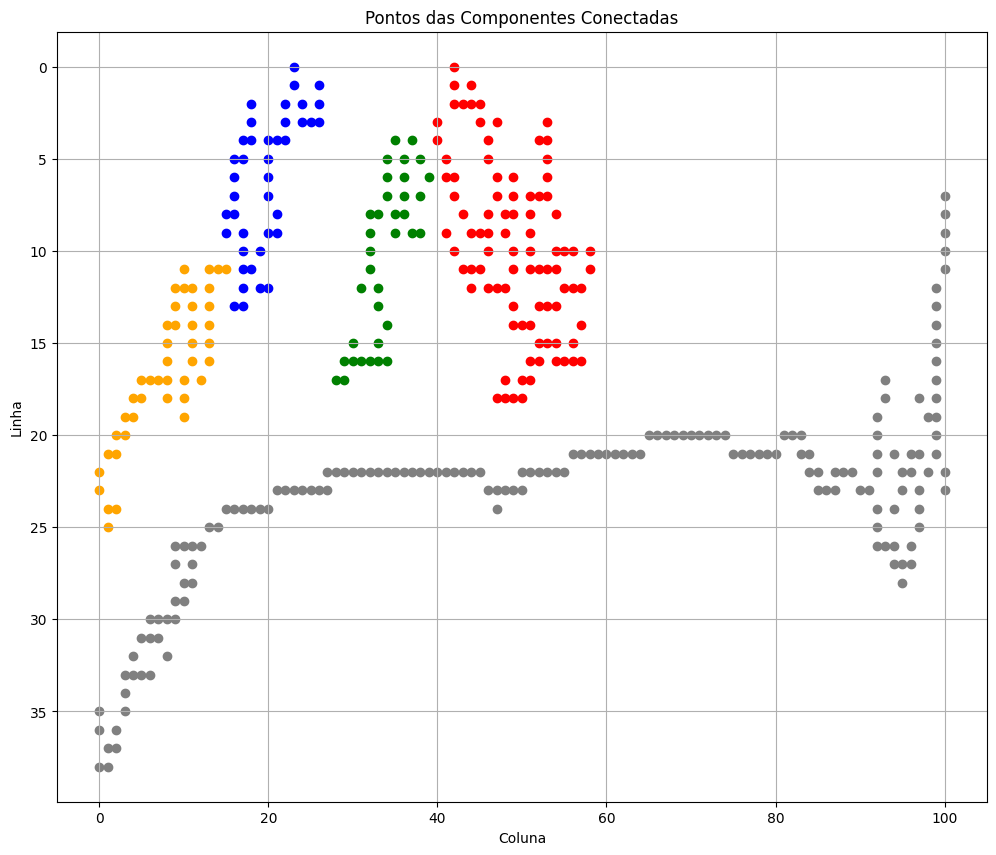

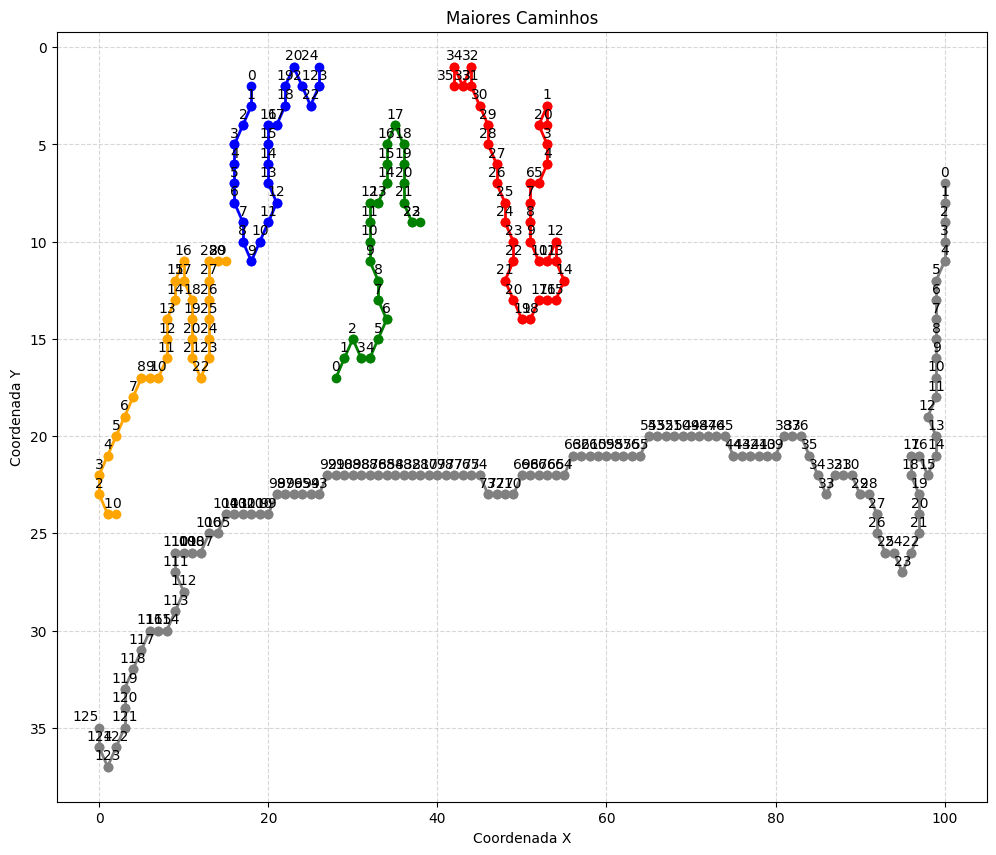

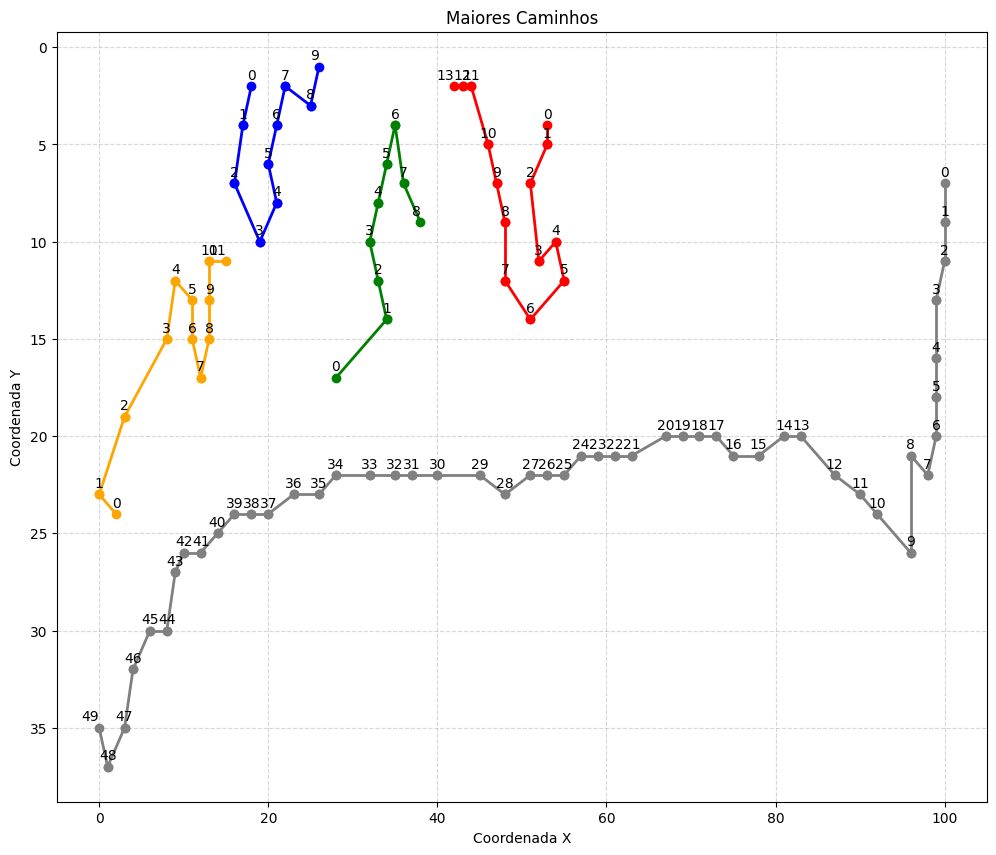

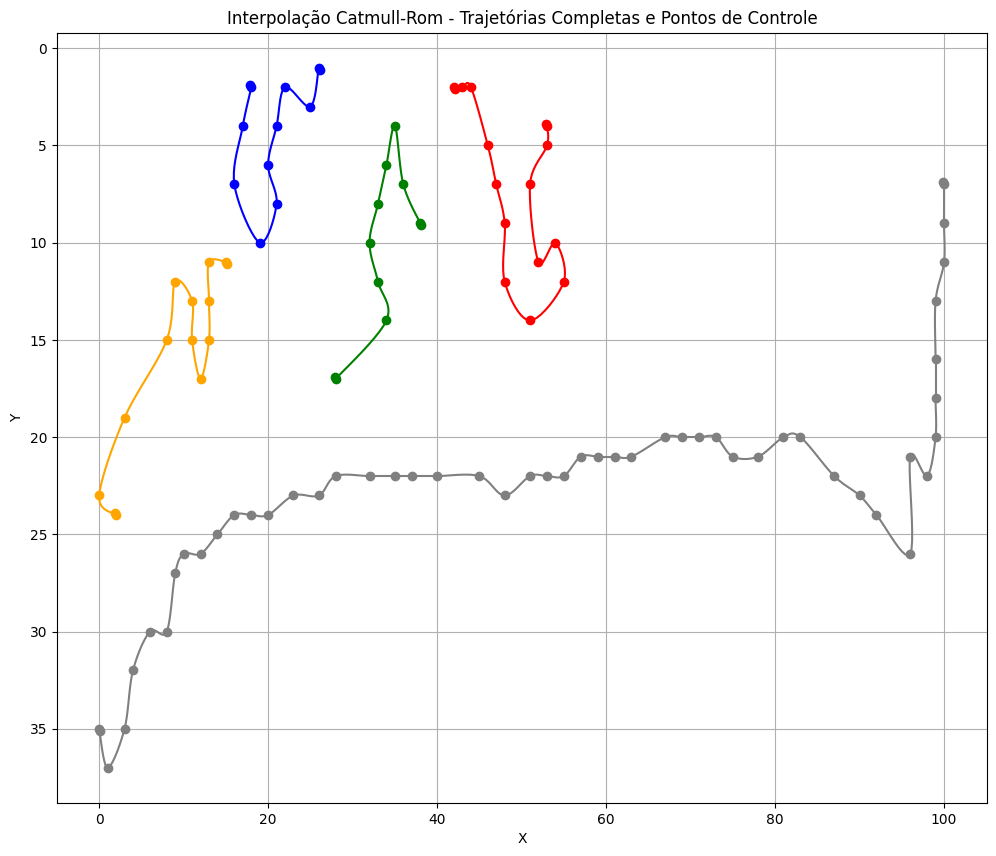

In [6]:

highlight_components(results[0][2].mouth_dict, results[0][4].dic_main_mouth_cc)
plot_logest_path(results[0][2].mouth_dict, results[0][6].longest_path_mouth, results[0][5].nodes_mouth)
plot_logest_path(results[0][2].mouth_dict, results[0][6].new_longest_path_mouth, results[0][5].nodes_mouth)
plot_splines(results[0][7].all_X_mouth, results[0][7].all_Y_mouth, results[0][7].all_control_x_mouth, results[0][7].all_control_y_mouth)